<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chapter10/Chapter10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import statsmodels.api as sm
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


우리가 관심을 가지고 있는 두 변수인 realdpi로 표시된 실질 가처분 소득과 realcons로 표시된 실질 소비를 도식화해보자

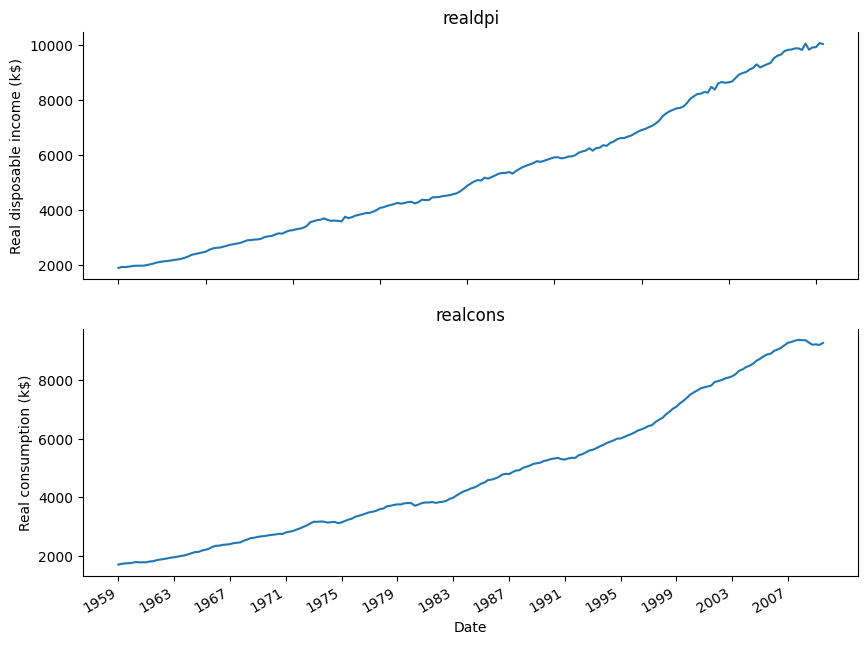

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel("Date")
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title("realdpi")
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel("Date")
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title("realcons")
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0,208, 16), np.arange(1959, 2010, 4))
fig.autofmt_xdate()

두 곡선이 시간에 따라 매우 유사한 모양을 가지므로, 이를 통해 직관적으로 VAR(p) 모델에 적합한 후보임을 알 수 있다.  
가처분 소득이 높으면 소비가 높을 가능성이 높다고 생각하는 것은 소비가 높으면 가처분 소득이 높다는 신호일 수 있으므로 합리적이다.  
물론 이 가설은 모델링 절차의 후반부에서 그레인저 인과관계 테스트를 사용하여 검증해야 한다.

이제 시계열이 정상적인지 확인해보자.

In [ ]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(macro_econ_data['realdpi'])
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  2.986025351954683
p-value :  1.0


In [ ]:
ADF_result = adfuller(macro_econ_data['realcons'])
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  1.549912338050964
p-value :  0.9976992503412904


두 변수 모두 p-value가 0.05보다 크므로, 귀무가설을 기각할 수 없으며, 모두 정상적이지 않다는 결론을 내릴 수 있다.  

두 시계열을 정상적으로 만들기 위해 변환을 적용해 보자.

In [ ]:
ADF_result = adfuller(np.diff(macro_econ_data['realdpi'],n=1))
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -8.864893340673007
p-value :  1.4493606159108096e-14


In [ ]:
ADF_result = adfuller(np.diff(macro_econ_data['realcons'],n=1))
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -4.204306080845247
p-value :  0.0006479282158627571


한 번의 차분만으로 정상적인 시계열을 얻을 수 있다.

In [ ]:
realdpi_diff1 = np.diff(macro_econ_data['realdpi'],n=1)
realcons_diff1 = np.diff(macro_econ_data['realcons'],n=1)

이제 여러 VAR(p) 모델을 피팅하여 AIC가 가장 작은 모델을 선택하여 보자.

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX


def optimize_VAR(endog : Union[pd.Series, list]) -> pd.DataFrame:
  results = []

  for i in tqdm_notebook(range(15)): # 0에서 14까지 차수 p를 변경해본다
    try :
      model = VARMAX(endog, order = (i,0)).fit(disp = False)
    except :
      continue

    aic = model.aic
    results.append([i,aic])
  results_df = pd.DataFrame(results)
  results_df.columns = ['p', 'AIC']
  results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
  return results_df

이제 이 함수를 사용하여 AIC를 최소화하는 차수 p를 선택할 수 있다.  

그에 앞서 먼저 훈련 집합과 테스트 집합을 정의해 보자.  
데이터의 80%를 훈련에 사용하고 20%를 테스트에 사용해보자.  


In [ ]:
endog = macro_econ_data[['realdpi', 'realcons']]
endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

가장 낮은 AIC 값을 갖는 모델은 VAR(3)이다.
따라서 각 시계열에서 과거의 값 3개를 사용하여 다른 시계열을 예측하는 것을 뜻한다.  


# 그레인저 테스트
이제 그레인저 테스트를 통해 realcons의 과거값이 realdpi를 예측하는 데 유용하고, realdpi의 과거값이 realcons를 예측하는데 유용한지 확인해보자

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
print("realcons Granger-causes realdp?\n")
print('---------------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi','realcons']].diff()[1:],[3]) # 3은 지연을 뜻한다

print("\nrealdpis Granger-causes realcons?\n")
print('---------------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons','realdpi']].diff()[1:],[3]) # 3은 지연을 뜻한다

realcons Granger-causes realdp?

---------------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpis Granger-causes realcons?

---------------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


두 테스트 모두 p-value가 0.05보다 작으므로, 귀무가설이 기각되어 realdpi가 그레인저 인과관계에 따라 realcons를 유발하고, realcons가 그레인저 인과관계에 따라 realdpi를 유발한다는 결론을 내릴 수 있다.  
따라서 우리의 VAR(3) 모델은 유효하다.

# 잔차 분석
이제 잔차 분석으로 넘어가보자

In [ ]:
best_model = VARMAX(train, order= (3,0))
best_model_fit = best_model.fit(disp = False)

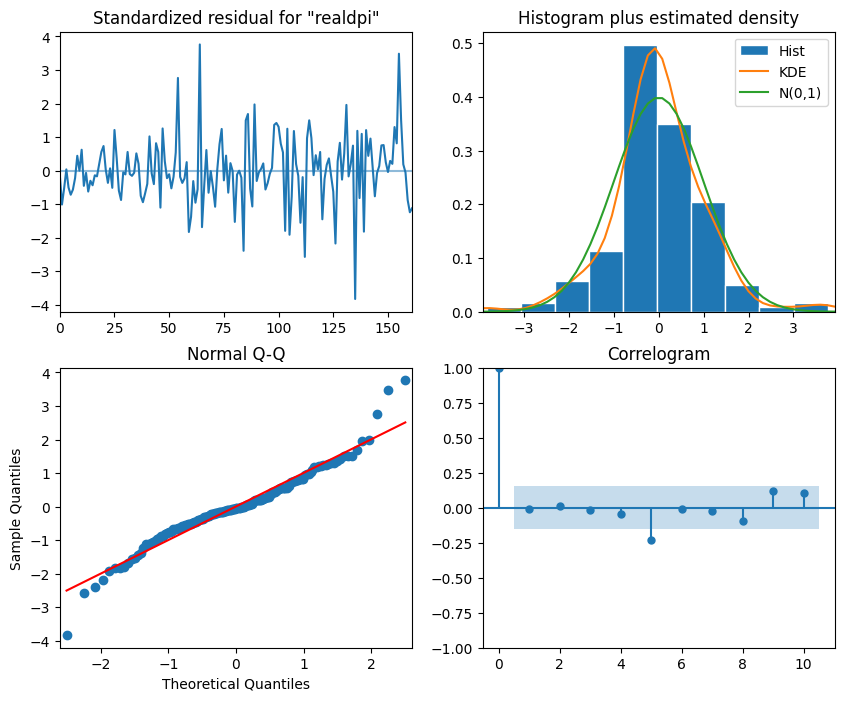

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable = 0); # realdpi의 잔차

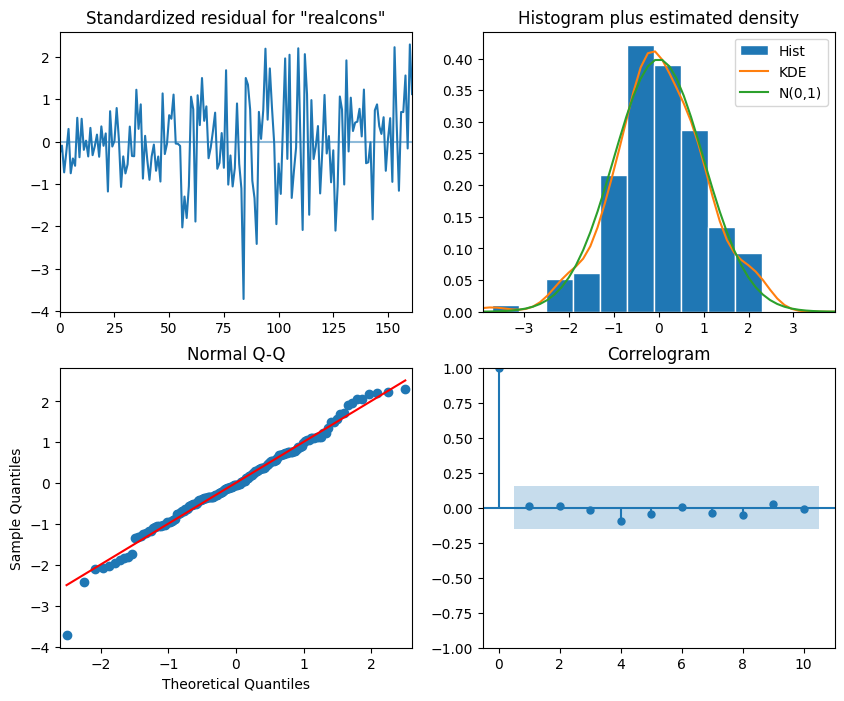

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8), variable = 1); # realcons의 잔차

두 변수의 잔차가 모두 백색소음과 매우 유사하다는 것을 볼 수 있다.

# 융 박스 테스트
이제 정량적 분석으로 넘어가보자

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = best_model_fit.resid['realdpi']
tr = acorr_ljungbox(residuals, np.arange(1,11,1)) # 처음 10개의 지연에 대해 융-박스 테스트를 수행
print(tr)

      lb_stat  lb_pvalue
1    0.011612   0.914186
2    0.029344   0.985435
3    0.075764   0.994578
4    0.377906   0.984246
5    9.142693   0.103506
6    9.165525   0.164481
7    9.270286   0.233829
8   10.811811   0.212592
9   13.318344   0.148723
10  15.287657   0.121921


In [ ]:
residuals = best_model_fit.resid['realcons']
tr = acorr_ljungbox(residuals, np.arange(1,11,1)) # 처음 10개의 지연에 대해 융-박스 테스트를 수행
print(tr)

     lb_stat  lb_pvalue
1   0.023938   0.877042
2   0.068593   0.966285
3   0.068671   0.995311
4   0.235629   0.993582
5   0.377724   0.995921
6   0.787370   0.992408
7   1.015365   0.994577
8   2.150655   0.976041
9   2.437317   0.982522
10  2.442979   0.991681


두 변수 모두 처음 10개의 지연에 대해 잔차간 상관관계가 없고 독립적이라고 볼 수 있다.

# 예측
모델이 잔차 분석의 정성적 측면과 정량적 측면을 모두 통과했으므로 이제 VAR(3) 모델을 사용하여 realcons와 realdpi를 예측할 수 있다.  
VAR(3) 모델을 단순히 마지막 관측값을 예측하는 베이스라인과 비교해보겠다.  
데이터가 분기별로 샘플링되므로 미래 4단계를 예측할 것이며, 이는 1년 전체를 예측하는 것과 같다.  


In [ ]:
optimum_order_list = (3,0)

from statsmodels.tsa.statespace.varmax import VARMAX

def rolling_forecast(df: pd.DataFrame,
                     train_len :int, horizon : int, window : int, method : str) -> list:
  total_len = train_len + horizon
  end_idx = train_len

  if method == 'last':
    realdpi_pred_last = []
    realcons_pred_last = []
    for i in range(train_len, total_len, window):
      realdpi_last = df[:i].iloc[-1]['realdpi']
      realcons_last = df[:i].iloc[-1]['realcons']
      realdpi_pred_last.extend(realdpi_last for _ in range(window))
      realcons_pred_last.extend(realcons_last for _ in range(window))
    return realdpi_pred_last, realcons_pred_last
  elif method == 'VAR':
    realdpi_pred_VAR = []
    realcons_pred_VAR = []

    for i in range(train_len, total_len, window):
      model = VARMAX(df[:i], order = optimum_order_list)
      res = model.fit(disp = False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
      oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
      realdpi_pred_VAR.extend(oos_pred_realdpi)
      realcons_pred_VAR.extend(oos_pred_realcons)

    return realdpi_pred_VAR, realcons_pred_VAR

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')
# 베이스라인은 차분하지 않은 endog를 집어넣는다

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
test['realdpi_pred_VAR'] = realdpi_pred_VAR
test['realcons_pred_VAR'] = realcons_pred_VAR
test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last
test

<ipython-input-107-d2902e5984dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realdpi_pred_VAR'] = realdpi_pred_VAR
<ipython-input-107-d2902e5984dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['realcons_pred_VAR'] = realcons_pred_VAR
<ipython-input-107-d2902e5984dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,121.8,102.8,63.324539,67.926623,7716.0,7199.9
164,165.7,112.1,67.964521,75.932089,7716.0,7199.9
165,82.5,70.5,63.374339,66.375050,7716.0,7199.9
166,86.4,74.1,54.194220,59.987335,7716.0,7199.9
167,12.3,67.6,65.943301,74.388623,8135.9,7571.8
168,61.9,30.8,61.690221,61.853379,8135.9,7571.8
169,-22.8,29.2,57.730809,61.025336,8135.9,7571.8
170,210.8,34.2,59.241815,58.676157,8135.9,7571.8
171,-99.0,122.3,5.023968,52.100603,8273.7,7773.5
172,226.1,27.3,56.472365,30.424741,8273.7,7773.5


## 역변환

In [ ]:
realdpi_pred_last

[7716.0,
 7716.0,
 7716.0,
 7716.0,
 8135.9,
 8135.9,
 8135.9,
 8135.9,
 8273.7,
 8273.7,
 8273.7,
 8273.7,
 8658.9,
 8658.9,
 8658.9,
 8658.9,
 8812.5,
 8812.5,
 8812.5,
 8812.5,
 9115.0,
 9115.0,
 9115.0,
 9115.0,
 9253.0,
 9253.0,
 9253.0,
 9253.0,
 9617.3,
 9617.3,
 9617.3,
 9617.3,
 9842.7,
 9842.7,
 9842.7,
 9842.7,
 10059.0,
 10059.0,
 10059.0,
 10059.0]

In [ ]:
test_realdpi_VAR_cumsum = test['realdpi_pred_VAR'].cumsum()
test_realcons_VAR_cumsum = test['realcons_pred_VAR'].cumsum()
# test_realdpi_last_cumsum = test['realdpi_pred_last'].cumsum()
# test_realcons_last_cumsum = test['realcons_pred_last'].cumsum()

endog['realdpi_pred_VAR'] = pd.Series()
endog.loc[163:,'realdpi_pred_VAR'] = endog.loc[162,'realdpi'] + test_realdpi_VAR_cumsum

# endog['realdpi_pred_last'] = pd.Series()
# endog.loc[163:,'realdpi_pred_last'] = endog.loc[162,'realdpi'] + test_realdpi_last_cumsum
endog.loc[163:, 'realdpi_pred_last'] =  realdpi_pred_last

endog['realcons_pred_VAR'] = pd.Series()
endog.loc[163:,'realcons_pred_VAR'] = endog.loc[162, 'realcons'] + test_realcons_VAR_cumsum

# endog['realcons_pred_last'] = pd.Series()
# endog.loc[163:,'realcons_pred_last'] = endog.loc[162, 'realcons'] + test_realcons_last_cumsum
endog.loc[163:,'realcons_pred_last'] = realcons_pred_last
endog[163:]

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224539,7354.326623,7716.0,7199.9
164,8053.4,7501.3,7897.189061,7430.258712,7716.0,7199.9
165,8135.9,7571.8,7960.5634,7496.633762,7716.0,7199.9
166,8222.3,7645.9,8014.75762,7556.621097,7716.0,7199.9
167,8234.6,7713.5,8080.70092,7631.00972,8135.9,7571.8
168,8296.5,7744.3,8142.391141,7692.863098,8135.9,7571.8
169,8273.7,7773.5,8200.12195,7753.888435,8135.9,7571.8
170,8484.5,7807.7,8259.363765,7812.564592,8135.9,7571.8
171,8385.5,7930.0,8264.387733,7864.665195,8273.7,7773.5
172,8611.6,7957.3,8320.860098,7895.089936,8273.7,7773.5


예측을 시각화해보자

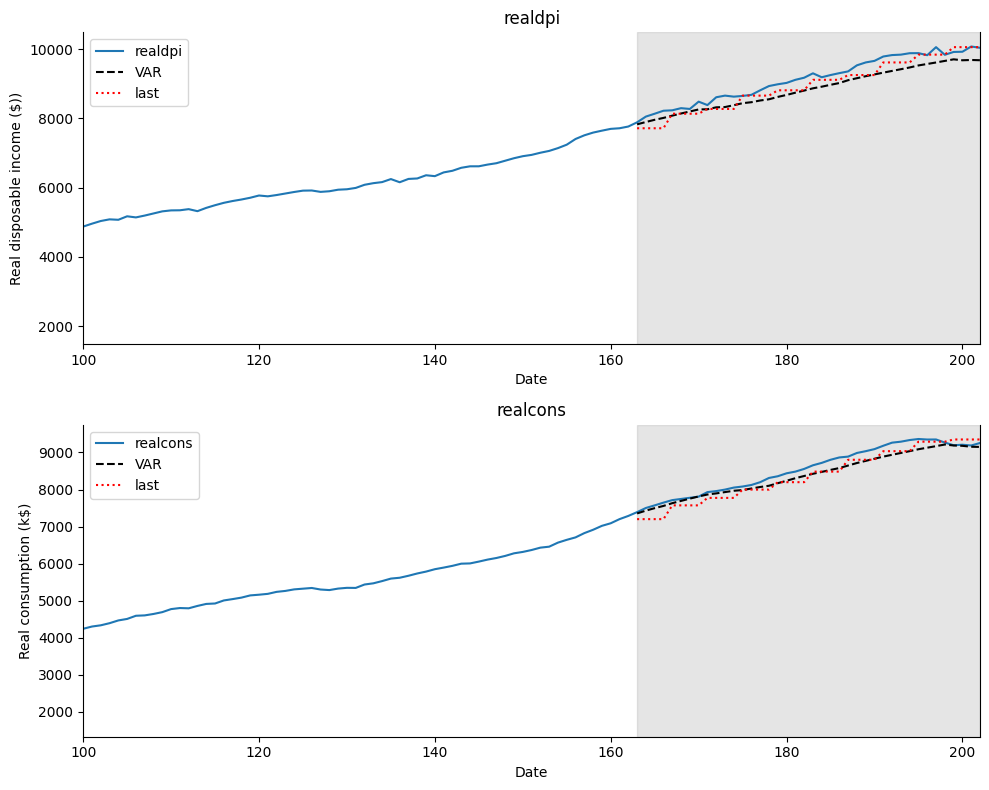

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (10,8))

ax1.plot(endog['realdpi'], label = 'realdpi')
ax1.plot(endog['realdpi_pred_VAR'], 'k--',label = 'VAR')
ax1.plot(endog['realdpi_pred_last'], 'r:', label = 'last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title("realdpi")
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163,202, color = '#808080', alpha = 0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc = 2)

ax2.plot(endog['realcons'], label = 'realcons')
ax2.plot(endog['realcons_pred_VAR'], 'k--', label = 'VAR')
ax2.plot(endog['realcons_pred_last'], 'r:', label = 'last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title("realcons")
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163,202, color = '#808080', alpha = 0.2)
ax2.set_xlim(100, 202)
ax2.legend()


plt.tight_layout()
plt.show()

# 성능비교

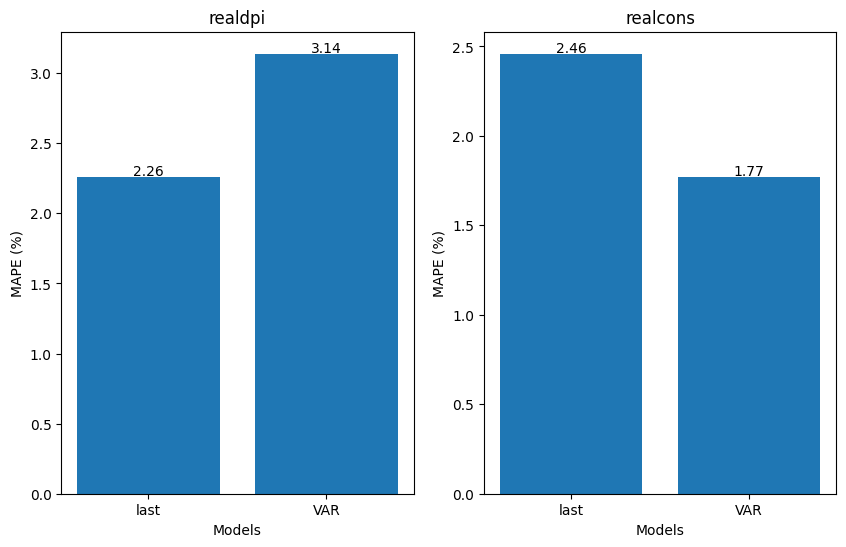

In [ ]:
def mape(y_true, y_pred):
  return np.mean(np.abs( (y_true - y_pred) / y_true)) * 100

mape_realdpi_last = mape(endog['realdpi'], endog['realdpi_pred_last'])
mape_realdpi_VAR = mape(endog['realdpi'], endog['realdpi_pred_VAR'])
mape_realcons_last = mape(endog['realcons'], endog['realcons_pred_last'])
mape_realcons_VAR = mape(endog['realcons'], endog['realcons_pred_VAR'])

model_realdpi_nm = ['last', 'VAR']
realdpi_maes = [mape_realdpi_last, mape_realdpi_VAR]

model_realcons_nm = ['last','VAR']
realcons_maes = [mape_realcons_last, mape_realcons_VAR]

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))
ax1.bar(model_realdpi_nm, realdpi_maes)
ax1.set_xlabel('Models')
ax1.set_ylabel('MAPE (%)')
ax1.set_title("realdpi")

for index, height in enumerate(realdpi_maes):
  ax1.text(x = index, y = height+0.01, s = str(round(height,2)), ha = 'center')

ax2.bar(model_realcons_nm, realcons_maes)
ax2.set_xlabel('Models')
ax2.set_ylabel('MAPE (%)')
ax2.set_title("realcons")

for index, height in enumerate(realcons_maes):
  ax2.text(x = index, y = height+0.01, s = str(round(height,2)), ha = 'center')


realdpi의 경우 VAR(3) 모델이 베이스라인 모델보다 성능이 나쁘지만, realcons의 경우 베이스라인 모델보다 성능이 더 좋은 것을 볼 수 있다.  

그레인저 인과관계 테스트는 통과했으나 realdpi의 경우, realcons이 베이스라인 모델보다 더 예측에 도움이 되지는 못한다는 가설을 세울 수 있다. 따라서 realdpi를 예측하기 위해서는 SARIMAX 모델을 사용해야 한다.  

결론적으로는 VAR(3) 모델만으로는 realdpi와 realcons를 정확하게 예측하기에는 충분하지 않으며, 두 개의 개별 모델을 사용하는 것이 나은데, 이 모델에는 realdpi와 realcons를 외생 변수로 포함하면서 이동평균 항도 포함하는 것이 나을 것이다.  